### MSc Computer Science, Data Science @UniPD
### Optimization Methods for Data Science
---

In [151]:
# Fix states
sklearn_random_state = 42
numpy_seed = 42

# Data preparation

In [152]:
class DataProperties:
    n_samples = 200 # 200
    labeled_percentage = 0.03
    n_dims = 2
    n_clusters = 2

    unlabeled = -1000000  # To mark the unlabelled data instance

In [153]:
from sklearn.datasets import make_blobs
import numpy as np
import random

from sklearn import datasets
import pandas as pd
import timeit

# Plotting
import matplotlib.pyplot as plt

np.random.seed(numpy_seed)


In [154]:
X, Y = make_blobs(
    n_samples = DataProperties.n_samples,
    centers = DataProperties.n_clusters,
    n_features = DataProperties.n_dims,
    random_state = sklearn_random_state
)
Y = Y.astype('float64')
clusters = np.unique(Y)

print(f'Data shape: X: {X.shape}, Y: {Y.shape}')

Data shape: X: (200, 2), Y: (200,)


## Visualize fully labeled data

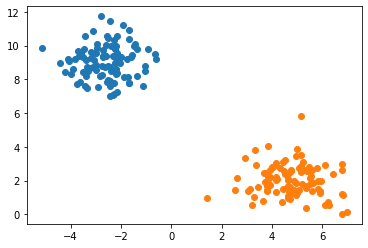

In [155]:
def plot_clusters(X, Y):
    fig, ax = plt.subplots()

    clusters = np.unique(Y)
    for c in clusters:
        mask = Y == c
        subset = X[mask]
        ax.scatter(
            subset[:, 0],
            subset[:, 1], 
            marker = 'o'
        )


plot_clusters(X, Y)

## Unlabel subset and visualize

In [156]:
def delabel_data (labeled_data, labeled_percent, delabel_value):
    res = np.ndarray.copy(labeled_data)
    clusters_ids = np.unique(labeled_data)

    for cluster_id in clusters_ids:
        # find indices of object, labeled as cluster_id
        # we keep 'labeled_percent' points still labeled

        cluster_indices = np.where(labeled_data == cluster_id)[0]
        print(f'Found {len(cluster_indices)} instances of object {cluster_id}')

        n_to_delabel = int(len(cluster_indices) * (1 - labeled_percent))
        print(f'We have to delabel {n_to_delabel} instances')

        # we choose data to delabel randomly
        indices_to_delabel = np.random.choice(
            len(cluster_indices - 1),
            n_to_delabel,
            replace = False
        )

        assert len(indices_to_delabel) == n_to_delabel, print(len(indices_to_delabel))
        assert np.max(indices_to_delabel) < len(res)
        assert np.max(indices_to_delabel) <= np.max(cluster_indices)

        res[
            cluster_indices[indices_to_delabel]
        ] = delabel_value
    return res

In [157]:
Y_delabeled = delabel_data(
    Y,
    labeled_percent = DataProperties.labeled_percentage,
    delabel_value = DataProperties.unlabeled
)

# assert(
#     len(Y_delabeled[Y_delabeled == DataProperties.unlabeled]) == int(len(Y) * (1 - DataProperties.labeled_percentage)),
# )

print(
    f'''
    We have {len(Y_delabeled[Y_delabeled == DataProperties.unlabeled])} unlabeled data
    Out of {len(Y_delabeled)}
    '''
)

Found 100 instances of object 0.0
We have to delabel 97 instances
Found 100 instances of object 1.0
We have to delabel 97 instances

    We have 194 unlabeled data
    Out of 200
    


## Visualize data after delabelling

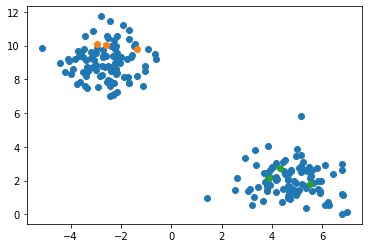

In [158]:
plot_clusters(X, Y_delabeled)

# Gradient Descent method

- Up to now, we have the clustered data, saved correct labelling (Y) and delabelled data (Y_delabelled)
- For the unlabelled y variables, the loss function depends on the (y_1, ..., y_U) unlabeled parameters. Each of the
parameters is independent on others, and can be 0 or 1 (for **binary clustering problem**). This is why we will be searching
for **optimal solution in the R^(U)** space, which yields minimum to the **loss function**

In [159]:
import collections
collections.Counter(Y_delabeled)

Counter({-1000000.0: 194, 1.0: 3, 0.0: 3})

In [160]:
def euclidian_similarity(X_i, X_j):
    return np.linalg.norm(X_i - X_j)  # sqrt( sum((x_ii - x_ji)^2) )

class GradientSolver:
    def __init__(
        self, 
        lr_strategy, 
        learning_rate, 
        similarity_func, 
        bcgd_strategy = None
    ):

        available_lr_strategies = [
            'lr_constant'
        ]
        assert lr_strategy in available_lr_strategies, print(f'Pick available lr_strategy: {available_lr_strategies}')

        self.lr_strategy = lr_strategy
        self.learning_rate = learning_rate
        self.similarity_func = similarity_func

        self.losses = []
        self.n_iterations = 0


    def get_learning_rate(self):
        if self.lr_strategy == 'lr_constant':
            return self.learning_rate   

    def compute_grad_component(self, X, Y, labeled_idxs, unlabeled_idxs, idx):

        grad_component = 0.0
            
        for labeled_idx in labeled_idxs:
            w_ij = np.linalg.norm(X[idx] - X[labeled_idx])
            grad_component += 2 * w_ij * (Y[idx] - Y[labeled_idx])

        for another_unlab_idx in unlabeled_idxs:
            w_ij_ = np.linalg.norm(X[idx] - X[another_unlab_idx])
            grad_component += 2 * w_ij_ * (Y[idx] - Y[another_unlab_idx])

        return grad_component

            
    def compute_grad(self, X, Y, labeled_idxs, unlabeled_idxs):

        grad = []
        for unlabeled_idx in unlabeled_idxs:
            # compute component of gradient for this 
            # current unlabeled
            grad_component = self.compute_grad_component(X, Y, labeled_idxs, unlabeled_idxs, idx=unlabeled_idx)
            grad.append(grad_component)

        return np.array(grad)

    def compute_loss(self, X, Y, labeled_idxs, unlabeled_idxs):
        res = 0
        for labeled_idx in labeled_idxs:
            for unlab_idx in unlabeled_idxs:
                w_ij = np.linalg.norm(X[labeled_idx] - X[unlab_idx])
                res += w_ij * ((Y[labeled_idx] - Y[unlab_idx]) ** 2)
        
        for unlab_idx in unlabeled_idxs:
            for another_unlab_idx in unlabeled_idxs:
                w_ij = np.linalg.norm(X[unlab_idx] - X[another_unlab_idx])
                res += 0.5 * w_ij * ((Y[unlab_idx] - Y[another_unlab_idx]) ** 2)
        
        return res
    
    def threshold_proc(self, Y_preds):
        Y_preds[Y_preds > 0.5] = 1.0
        Y_preds[Y_preds <= 0.5] = 0.0
        return Y_preds
        

In [161]:
class GradientDescentSolver(GradientSolver):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def solve(self, X, Y, iter_limit, delta_loss_limit):

        labeled_idxs = np.where(Y != DataProperties.unlabeled)[0]
        unlabeled_idxs = np.where(Y == DataProperties.unlabeled)[0]

        Y_res = np.ndarray.copy(Y)
        
        # fix initial approximation
        Y_res[Y_res == DataProperties.unlabeled] = 0.5

        loss_prev = 0.0
        self.losses = []
        self.n_iterations = 0
        for i in range(iter_limit):
            loss = self.compute_loss(X, Y_res, labeled_idxs, unlabeled_idxs)
            self.losses.append(loss)
            delta_loss = abs(loss - loss_prev)
            print(f'Loss: {loss}, delta loss: {delta_loss}')


            if (i > 0 and delta_loss < delta_loss_limit):
                break
            else:
                grad = self.compute_grad(X, Y_res, labeled_idxs, unlabeled_idxs)

                learning_rate = self.get_learning_rate()
                updates = -learning_rate * grad
  
                # print(f'Max update: {np.max(updates)}')

                assert len(unlabeled_idxs) == len(grad)
                for i in range(len(grad)):
                    Y_res[unlabeled_idxs[i]] += updates[i]
                
                loss_prev = loss
                self.n_iterations += 1

        
        return self.threshold_proc(Y_res)
        

In [162]:
# solver = GradientDescentSolver(
#     similarity_func = euclidian_similarity,
#     lr_strategy = 'lr_constant',  # search for alpha_k
#     learning_rate = 0.00014
# )

In [163]:
# Y_preds_GD = solver.solve(
#     X,
#     Y_delabeled,
#     iters_limit = 50,
#     delta_loss_limit = 0.0025
# )

In [164]:
# plot_clusters(X, Y_preds_GD)

In [165]:
# plt.plot(solver.losses)
# plt.grid()

# Block coordinates gradient descent (randomized)

## BCGD random permutations

In [166]:
class BCGDSolver(GradientSolver):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        available_strategies = [
            # 'cyclic_order',
            'random permutation',
            'random sampling',
            'cyclic'
        ]

        block_strategy = kwargs['bcgd_strategy']
        assert block_strategy in available_strategies, \
            print(f'Please choose available block strategy: {available_strategies}')
        
        self.block_strategy = block_strategy
        # strategies - random permutation & random sampling

    def pick_block_indices(self, unlabeled_indices):
        
        if self.block_strategy == 'random permutation':
            # we just permute the dimensions
            return np.random.permutation(unlabeled_indices)
        if self.block_strategy == 'random sampling':
            return [random.choice(unlabeled_indices)]
        if self.block_strategy == 'cyclic':
            return unlabeled_indices


    def solve(self, X, Y, iter_limit, delta_loss_limit):

        Y_res = np.ndarray.copy(Y)
        labeled_indices = np.where(Y_res != DataProperties.unlabeled)[0]
        unlabeled_indices = np.where(Y_res == DataProperties.unlabeled)[0]
        assert len(labeled_indices) + len(unlabeled_indices) == len(Y_res)

        # Step 1. Choose initial point
        Y_res[unlabeled_indices] = 0.5

        loss_prev = 0
        self.losses = []
        self.n_iterations = 0
        for i in range(iter_limit):

            loss = self.compute_loss(X, Y_res, labeled_indices, unlabeled_indices)
            self.losses.append(loss)
            delta_loss = abs(loss - loss_prev)
            loss_prev = loss
            print(f'LOSS: {loss}, Delta: {delta_loss}')

            # Specific condition
            if (i > 0) and delta_loss <= delta_loss_limit:
                break
            else:
                y = np.ndarray.copy(Y_res)  # y_0
                del Y_res

                # depending on the strategy,
                # S contains one random block, permutation
                # of available coordinates, or same sequence of
                # coordinates (for cyclic approach)
                S = self.pick_block_indices(unlabeled_indices)  # Pick random permutation of unlabeled indices
                
                # print(f'Picked: {S}')
                
                # l = len(S)
                # And now we move across S and update y variable
                for index in S:
                    assert(index in unlabeled_indices)
                    learning_rate = self.get_learning_rate()
                    
                    grad_component = self.compute_grad_component(
                        X,
                        y,
                        labeled_indices,
                        unlabeled_indices,
                        idx = index
                    )
                    grad_vector = np.zeros(y.shape[0])
                    grad_vector[index] = grad_component
                    y = y - learning_rate * grad_vector
                
                Y_res = y
                del y
                self.n_iterations += 1
        return self.threshold_proc(Y_res)

In [167]:
# random_solver = BCGDSolver(
#     lr_strategy = 'lr_constant',
#     learning_rate = 0.0001,
#     similarity_func = euclidian_similarity,

#     bcgd_strategy = 'random permutation',
# )

In [168]:
# Y_preds_BCGD_permutation = random_solver.solve(
#     X,
#     Y_delabeled,
#     iter_limit = 50,
#     delta_loss_limit = 0.008
# )

In [169]:
# plot_clusters(X, Y_preds_BCGD_permutation)

In [170]:
# plt.plot(random_solver.losses)
# plt.grid()

## BCGD random sampling

In [171]:
# BCGD_RS_solver = BCGDSolver(
#     lr_strategy = 'lr_constant',
#     learning_rate = 0.0001,
#     similarity_func = euclidian_similarity,

#     bcgd_strategy = 'random sampling'
# )

In [172]:
# Y_preds_BCGD_sampling = BCGD_RS_solver.solve(
#     X = X, 
#     Y = Y_delabeled, 
#     iter_limit = 50,
#     delta_loss_limit = 0.001
# )

In [173]:
# plot_clusters(
#     X, Y_preds_BCGD_sampling
# )

In [174]:
# plt.plot(BCGD_RS_solver.losses)
# plt.grid()

## BCGD cyclic

In [175]:
# BCGD_cyclic_solver = BCGDSolver(
#     lr_strategy = 'lr_constant',
#     learning_rate = 0.0001,
#     similarity_func = euclidian_similarity,

#     bcgd_strategy = 'cyclic'
# )

In [176]:
# Y_preds_BCGD_cyclic = BCGD_cyclic_solver.solve(
#     X,
#     Y_delabeled, 
#     iter_limit = 50, 
#     delta_loss_limit = 0.01
# )

In [177]:
# plot_clusters(
#     X, Y_preds_BCGD_cyclic
# )

In [178]:
# plt.plot(BCGD_cyclic_solver.losses)
# plt.grid()

# Model comparison

We will compare models based on:
- Clustering metrics
- CPU time
- Number of iterations
- Loss curves
- Distance metrics

In [179]:
learning_rate_strategy = 'lr_constant'
simil_func = euclidian_similarity
lr = 0.0001

gd_solver = GradientDescentSolver(
    similarity_func = simil_func,
    lr_strategy = learning_rate_strategy,
    learning_rate = lr
)

bcgd_permut_solver = BCGDSolver(
    lr_strategy = learning_rate_strategy,
    learning_rate = lr,
    similarity_func = simil_func,
    bcgd_strategy = 'random permutation',
)

bcgd_sampling_solver = BCGDSolver(
    lr_strategy = learning_rate_strategy,
    learning_rate = lr,
    similarity_func = simil_func,
    bcgd_strategy = 'random sampling',
)

bcgd_cyclic_solver = BCGDSolver(
    lr_strategy = learning_rate_strategy,
    learning_rate = lr,
    similarity_func = simil_func,
    bcgd_strategy = 'cyclic',
)

In [180]:
solvers = {
    'GD': gd_solver,
    'BCGD permutation': bcgd_permut_solver,
    # 'BCGD cyclic': bcgd_cyclic_solver,
    # 'BCGD sampling': bcgd_sampling_solver,
}

In [181]:
def compare_models(solvers_dict, X, Y_delabeled, iters_limit, delta_loss_limit):
    predictions = {k:None for k in solvers_dict.keys()}
    losses = {k:None for k in solvers_dict.keys()}
    n_iterations = {k:None for k in solvers_dict.keys()}
    cpu_times = {k:None for k in solvers_dict.keys()}

    for model_name, model in solvers_dict.items():
        start = timeit.default_timer()
        Y_preds = model.solve(
            X,
            Y_delabeled,
            iter_limit = iters_limit,
            delta_loss_limit = delta_loss_limit
        )
        end = timeit.default_timer()
        predictions[model_name] = Y_preds
        losses[model_name] = model.losses
        n_iterations[model_name] = model.n_iterations
        cpu_times[model_name] = end - start
    
    # plot_accuracies(predictions)
    # plot_losses(losses)
    # plot_iterations(n_iterations)
    # plot_cpu_times(cpu_times)

    return predictions, losses, n_iterations, cpu_times

In [182]:
preds, losses, n_iters, cpu_times = compare_models(
    solvers,
    X,
    Y_delabeled,
    iters_limit = 5,
    delta_loss_limit = 0.003
)

accuracies = {name: accuracy_score(preds[name], Y) for name in solvers.keys()}

Loss: 1724.1510344949693, delta loss: 1724.1510344949693
Loss: 1713.1971599430099, delta loss: 10.953874551959416
Loss: 1709.3690723906388, delta loss: 3.8280875523710165
Loss: 1708.0048667745812, delta loss: 1.3642056160576885
Loss: 1707.4982816469028, delta loss: 0.5065851276783633
LOSS: 1724.1510344949693, Delta: 1724.1510344949693
LOSS: 1713.8615750880172, Delta: 10.289459406952119
LOSS: 1709.8522692651052, Delta: 4.009305822911983
LOSS: 1708.2644012583971, Delta: 1.5878680067080495
LOSS: 1707.6165748214478, Delta: 0.6478264369493445


In [184]:
# print(preds)
# print(losses)
# print(n_iters)
# print(cpu_times)

{'GD': [1724.1510344949693, 1713.1971599430099, 1709.3690723906388, 1708.0048667745812, 1707.4982816469028], 'BCGD permutation': [1724.1510344949693, 1713.8615750880172, 1709.8522692651052, 1708.2644012583971, 1707.6165748214478]}
{'GD': 5, 'BCGD permutation': 5}
{'GD': 2.4604663000000073, 'BCGD permutation': 2.4401688999996622}


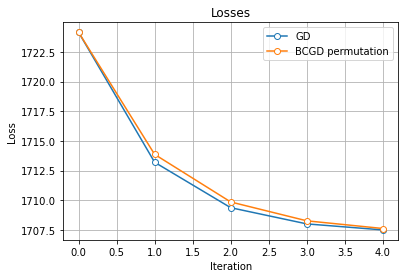

In [203]:
def plot_curves(curves_dict, title, y_label):
    _, ax = plt.subplots()

    for _, curve_res in curves_dict.items():
        ax.plot(
            curve_res,
            marker = 'o',
            markerfacecolor = 'white'   
        )
    plt.legend(list(curves_dict.keys()))
    plt.title(title)
    plt.xlabel('Iteration')
    plt.ylabel(y_label)
    plt.grid()


plot_curves(losses, 'Losses', y_label = 'Loss')

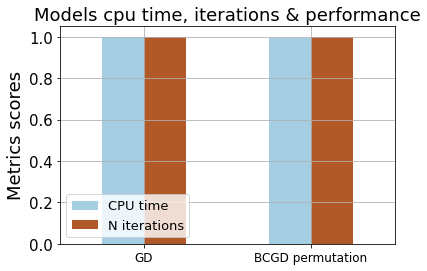

In [202]:
# For cpu_time, n_iters and accuracy its better to use
# bar plot
# plot_bars(cpu_times, 'CPU times', 'CPU time')

def plot_bar_metrics(metrics_df):
    ax = metrics_df.plot.bar(
        rot = 0,
        ylabel = 'Metrics results',
        cmap = 'Paired'
    )

    ax.set_title('Models cpu time, iterations & performance', fontsize = 18)
    ax.set_ylabel('Metrics scores', fontsize = 18)
    ax.tick_params(axis = 'y', labelsize = 15)
    ax.tick_params(axis = 'x', labelsize = 12)
    ax.legend(loc = 3, prop = {'size': 13})
    plt.grid()

def normalize_cols(dataframe):
    cols = dataframe.columns
    for c in cols:
        dataframe[c] = dataframe[c] / dataframe[c].max()
    

bar_metrics = pd.DataFrame.from_dict(cpu_times, orient='index', columns = ['CPU time'])
bar_metrics['N iterations'] = n_iters.values()
# bar_metrics['Performance'] = accuracies.values()

normalize_cols(bar_metrics)
plot_bar_metrics(bar_metrics)

# Real dataset

In [86]:
wine=datasets.load_wine()

#Conver to pandas dataframe
data=pd.DataFrame(data=np.c_[wine['data'],wine['target']],columns=wine['feature_names']+['target'])

data = data.loc[
    (data['target'] == 1) | (data['target'] == 0),
    ['od280/od315_of_diluted_wines', 'alcohol', 'target']
]

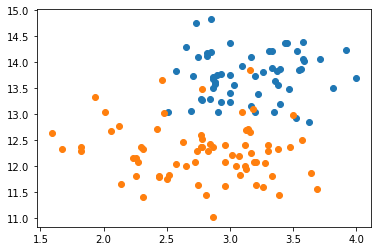

In [88]:
X_real = data.loc[
    :,
    ['od280/od315_of_diluted_wines', 'alcohol']
].values
Y_real = data['target'].values

plot_clusters(
    X_real,
    Y_real
)

In [89]:
Y_real_delabeled = delabel_data(
    Y_real,
    labeled_percent = DataProperties.labeled_percentage,
    delabel_value = DataProperties.unlabeled
)

Found 59 instances of object 0.0
We have to delabel 57 instances
Found 71 instances of object 1.0
We have to delabel 68 instances


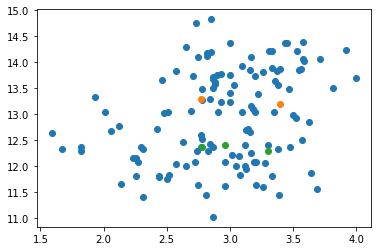

In [100]:
plot_clusters(
    X_real,
    Y_real_delabeled
)

In [99]:
solver = GradientDescentSolver(
    lr_strategy = 'lr_constant',
    learning_rate = 0.001,
    similarity_func = euclidian_similarity
)

Y_real_preds = solver.solve(
    X_real,
    Y_real_delabeled,
    iters_limit=500,
    delta_loss_limit = 0.00015
)

Loss: 162.6629925569497, delta loss: 162.6629925569497
Loss: 162.16646506322778, delta loss: 0.4965274937219135
Loss: 161.91062781614332, delta loss: 0.25583724708445743
Loss: 161.72313923725804, delta loss: 0.18748857888527937
Loss: 161.55858221519566, delta loss: 0.16455702206238243
Loss: 161.40384677816846, delta loss: 0.15473543702719894
Loss: 161.25470617996586, delta loss: 0.1491405982025924
Loss: 161.10962093908006, delta loss: 0.14508524088580543
Loss: 160.96795404916315, delta loss: 0.14166688991690535
Loss: 160.8294034888473, delta loss: 0.13855056031584922
Loss: 160.69380270394876, delta loss: 0.13560078489854277
Loss: 160.56104386826922, delta loss: 0.13275883567953883
Loss: 160.43104615614013, delta loss: 0.1299977121290965
Loss: 160.30374188942739, delta loss: 0.1273042667127413
Loss: 160.1790702387526, delta loss: 0.12467165067479868
Loss: 160.0569742687593, delta loss: 0.1220959699932962
Loss: 159.9373995153832, delta loss: 0.11957475337609935
Loss: 159.82029328322756, 

In [98]:
Y_real_preds

array([1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

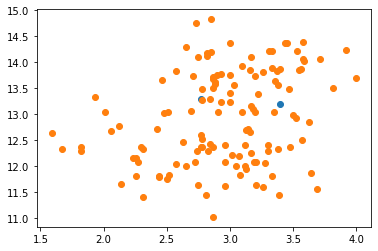

In [97]:
plot_clusters(
    X_real,
    Y_real_preds
)